# Tutorial: ACCorDIoN test data

James S. Nagai

02.05.2023

*Note: Before using ACCorDIoN make sure that you have the CrossTalkeR installed in your local R enviroment([github](https://costalab.github.io/CrossTalkeR/))*

Here we introduce scACCorDIoN. In this notebook, we guide you into the framework steps.


## Load Libraries

In [1]:
from scaccordion import tl as actl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pydiffmap as dm
import pandas as pd
import networkx as nx
from skimpy import skim
from sklearn import covariance
import conorm
import phate
import warnings
import kmedoids
import numpy as np
from tqdm import tqdm
import ot
from sklearn import manifold
warnings.filterwarnings("ignore")

2024-08-13 10:41:31.255943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.19) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### 1. Loading data and metadata
Here, we explore the [Pancreas Adenocarcinoma Cohort](https://www.nature.com/articles/s41422-019-0195-y)(Peng et.al.,2019). The data available in scACCorDiON were pre-processed. The Ligand-Receptor inference were performed using the CellphoneDB methods (Efremova et. al., 2020) implemented in [LIANA](https://liana-py.readthedocs.io/en/latest/)(Dimitrov et. al.,2022). Networks were generated using [CrossTalkeR](https://costalab.github.io/CrossTalkeR/)(Nagai et. al., 2021)

In [2]:
data = actl.datasets.load_peng2019()
pdata_metadata = actl.datasets.load_peng2019_metadata()
pdata_metadata['label1'] = ['Normal Pancreas' if i.find('normal')>= 0 else 'PDAC' for i in pdata_metadata.accLabel]

#### 1.1. This are tables made by CrossTalkeR/Liana therefore we need to filter it to keep only the single(per sample) networks

In [3]:
data = {i:data[i] for i in data.keys()  if i.find("_x_") < 0 }

### 2. Now with the tables from CrossTalkeR/Liana we build the Accordion Object 

In [4]:
def norm(x):
    '''
        Defining the normalization function.
    '''
    nf = conorm.tmm(x+1e-5,trim_lfc=0,trim_mag=0)
    return (nf)

##### Creating an Accordion Object

In [5]:
AaccPDAC = actl.Accordion(tbls=data,weight='lr_means',normf=norm)

### 3. Computing a PCA using the edge distribuition per sample

Text(0, 0.5, 'PC2')

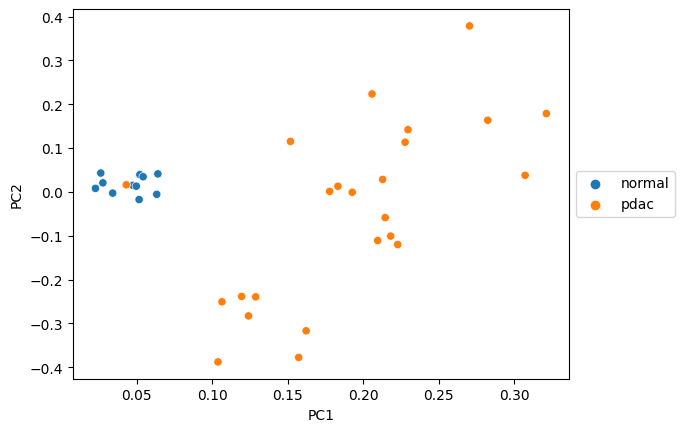

In [6]:
AaccPDAC.make_pca()
sns.scatterplot(x=AaccPDAC.Cs['PCA'][0],y=AaccPDAC.Cs['PCA'][1],
                hue=pdata_metadata.loc[AaccPDAC.Cs['PCA'].index,'accLabel'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("PC1")
plt.ylabel("PC2")


### 4 Optimal Transport: Wasserstein

In this step we compute the graph-to-graph distance solving the Optimal Transport minimization problem. Note that, the Optimal Transport is done in two main steps: (1) we use the function **compute_cost()** to compute an edge-to-edge distance and (2) we use the edge weights and the cost to get a graph-to-graph distance matrix using **compute_wasserstein()**
```{python}
AaccPDAC.compute_cost_all() ## Run all the possible cost matrices
```

In [7]:
AaccPDAC.compute_cost(mode='HTD') # Computing the cost
AaccPDAC.compute_wassestein(cost='HTD_0.5') # Getting the sample-to-sample distance

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 56.99it/s]


##### Metric Evaluation using K-means and the original labels

In [8]:
dt=AaccPDAC.eval_all(y=pdata_metadata.loc[AaccPDAC.p.columns,'label1'].astype('category').cat.codes)

In [9]:
dt

{'HTD_0.5': {'ARS': 0.8847766158612991,
  'Silhouette_Wass': 0.42117741927509833,
  'Silhouette': 0.48775082937226577}}

### 5 Clustering using the graph-to-graph distance

In this step we compute the clustering methods mentioned in our manuscript, note that two clustering approaches are show:

    1. KMedoids
    2. KBarycenters

#### 5.1 Here we compute the K-medoids

In [10]:
km = kmedoids.KMedoids(n_clusters=3, method='fasterpam')
plt.figure(figsize=(6,5))
c = km.fit(AaccPDAC.wdist['HTD_0.5'].to_numpy())
X =np.round(AaccPDAC.wdist['HTD_0.5'].loc[AaccPDAC.wdist['HTD_0.5'].index,AaccPDAC.wdist['HTD_0.5'].index],5)


<Figure size 600x500 with 0 Axes>

#### 5.2.1 Here we compute the K-barycenters

In [11]:
clust,loss = [],[]
for _ in tqdm(range(100)):
    kmeans = actl.KBarycenters(k=3,init='++',random_state=42,max_iters=100)
    kmeans.fit(X,distr=AaccPDAC.p,cost=AaccPDAC.Cs['HTD_0.5'])
    clust.append(kmeans)
    loss.append(kmeans.centroids.mean().mean())
ncls= clust[np.argmin(loss)]

100%|█████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


### 5.2.2 Updating the distance matrix with the Barycenters

In [12]:
aux = ncls.centroids.to_dict()
for i in range(3):
    for j in range(i,3):
        if i!=j:
            aux[i][j] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=AaccPDAC.Cs['HTD_0.5'])
            aux[j][i] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=AaccPDAC.Cs['HTD_0.5'])
        else:
            aux[i][j] = 0
eux = pd.concat([AaccPDAC.wdist['HTD_0.5'],ncls.centroids],axis=1)
eux = pd.concat([eux,pd.DataFrame.from_dict(aux).T])
tmplab = ncls.flabels.tolist()
for i in [0,1,2]:
    tmplab.append(i) 

##### Defining the barycenters

In [13]:
tmpstl = ['0']*len(AaccPDAC.p.columns)+['1']*3

### 5.2.3 Computing the new embeddings and plotting the new data representation 

In [14]:
import phate

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 38 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 35
  Calculating diffusion potential...
  Calculating metric MDS...


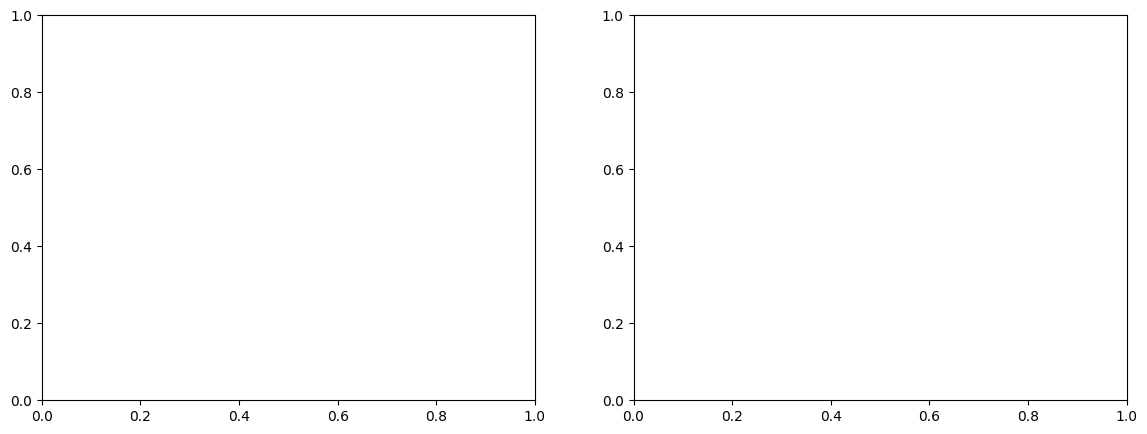

In [15]:
emb1 = phate.PHATE(knn=10,knn_dist='precomputed',random_state=42)
emb1 = emb1.fit_transform(eux.to_numpy())
fs,axs = plt.subplots(1,2,figsize=(14,5))
axs = axs.ravel()

#### Prepare the embedding the barycenters and the colormap

In [16]:
barys = pd.DataFrame(ncls.bary,index=AaccPDAC.p.index)
barys.reset_index(inplace=True)
barys[['u', 'v']] = barys['index'].str.split('$', expand=True)
cmapse =[plt.cm.Greens,plt.cm.Blues,plt.cm.Reds]
vtxcmap = {i[1]:plt.cm.tab10.colors[i[0]] for i in enumerate(AaccPDAC.nodes)}

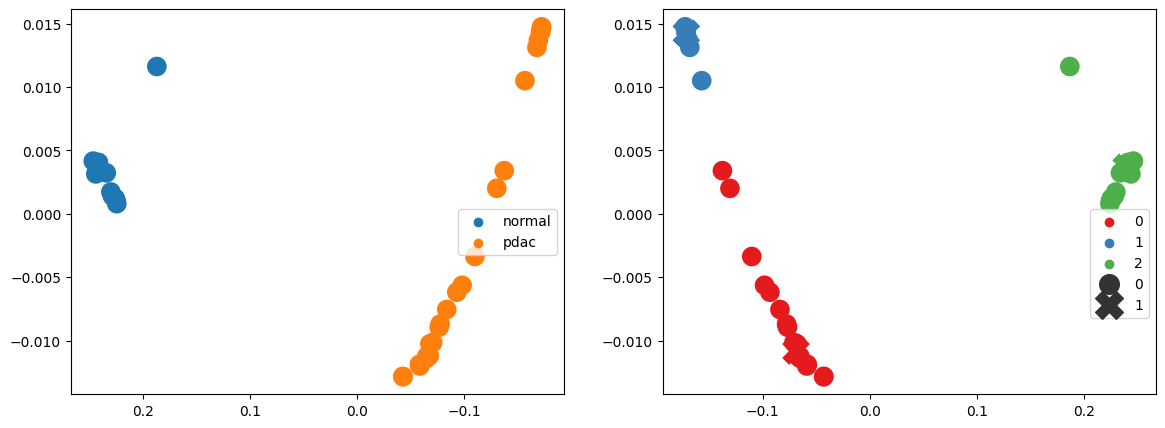

In [17]:
sns.scatterplot(x=emb1[0:-3,0],
                y=emb1[0:-3,1],hue=pdata_metadata.loc[AaccPDAC.Cs['PCA'].index,'accLabel'],s=200,linewidth=0,ax=axs[0])
axs[0].legend(loc=0, bbox_to_anchor=(1, 0.5))
axs[0].invert_xaxis()
sns.scatterplot(x=emb1[:,0],
                y=emb1[:,1],hue=tmplab,s=200,style=tmpstl,palette=list(plt.cm.Set1.colors)[0:3],
                size=tmpstl,sizes=(400,200),linewidth=0,ax=axs[1])
axs[1].legend(loc=0, bbox_to_anchor=(1, 0.5))
#axs[1].invert_xaxis()
fs

In [18]:
import scaccordion

In [19]:
print(scaccordion.__version__)

0.1.9.9
